# Transitions NREM-REM

In [1]:
import sys
import itertools

import numpy as np
import pandas as pd
import scipy.signal
from scipy.signal import savgol_filter

from tqdm import tqdm

import neuroseries as nts


import time
import matplotlib.pyplot as plt
# %matplotlib qt

import seaborn as sns 
import bk.load
import bk.compute
import bk.plot

import os
%load_ext memory_profiler
import cProfile

In [2]:
import matplotlib as mpl
# COLOR = 'white'
# mpl.rcParams['text.color'] = COLOR
# mpl.rcParams['axes.labelcolor'] = COLOR
# mpl.rcParams['axes.edgecolor'] = COLOR
# mpl.rcParams['xtick.color'] = COLOR
# mpl.rcParams['ytick.color'] = COLOR
# mpl.rcParams['figure.facecolor'] = '#282C34'
# mpl.rcParams['axes.facecolor'] = '#282C34'
mpl.rcParams['svg.fonttype'] = 'none'
# %matplotlib qt

# Utils Functions

In [3]:
def transition(states, template,epsilon = 0):
    '''
    author: BK
    states : dict of nts.Interval_set
    template : list of state.
    epsilon : int, will drop any transition in which there is an epoch shorter than epsilon 's'
    This function will find transition that match the template 
    '''
    
    long = pd.DataFrame()
    for s,i in states.items():
        i['state'] = s
        long = pd.concat((i,long))
        del i['state']
    order = np.argsort(long.start)
    long = long.iloc[order]
    
    transition_times = []
    transition_intervals = []
    for i,s in enumerate(long.state):
        tmp = list(long.state[i:i+len(template)])
        if tmp == template:
            tmp_transition = long.iloc[i:i+len(template)]
#             print(d.iloc[i:i+len(template)])
            length = (tmp_transition.end - tmp_transition.start)/1_000_000
            if np.any(length.values<epsilon): 
                continue
            tmp_pre = np.array(tmp_transition.end[:-1])
            tmp_post = np.array(tmp_transition.start[1:])
            tmp_times = np.mean([tmp_pre,tmp_post],0)
            
            
            transition_intervals.append([tmp_transition.start.iloc[0],tmp_transition.end.iloc[-1]])
            transition_times.append(tmp_times)
    
    transition_times = np.array(transition_times)
    transition_intervals = np.array(transition_intervals)
    transition_intervals = nts.IntervalSet(start = transition_intervals[:,0],end = transition_intervals[:,1],force_no_fix = True)
    return transition_intervals,transition_times

## Computing

In [4]:
def sanity_check(neurons,states,intervals):
    plt.ioff()
    f = plt.figure(figsize=(12,4),dpi = 300)
    ax = plt.subplot(3,1,1)
    plt.suptitle(f'Rat : {bk.load.rat} Day : {bk.load.day} - {bk.load.session}')
    
    for k,s in states.items():
        if   k == 'Rem'    : c = 'orange'
        elif k == 'sws'    : c = 'grey'
        elif k == 'wake'   : c = 'pink'
        elif k == 'drowsy' : c = 'green'
            
        bk.plot.intervals(s,c)

    
    plt.subplot(3,1,2,sharex = ax)
    bk.plot.intervals(intervals)
    
    plt.subplot(3,1,3,sharex = ax)
    bk.plot.rasterPlot(neurons)
    plt.tight_layout()
    plt.savefig(f'/home/billel/figs/{bk.load.session}.jpeg')
    f.clear()
    plt.close(f)
#     lfp = bk.load.loadLFP()
#     plt.subplot(4,1,4,sharex = ax)
#     plt.plot(lfp.as_units('s'))
    

In [20]:
def main(local_path = 'Rat08/Rat08-20130713',plot = False, save = False):
    
    #Variables : 
    transition_interest = [['sws','Rem','sws']] #Template of transitions to follow.
    bin_epochs = [30,12,30]
    
    bk.load.current_session_linux(local_path = local_path)
    neurons,metadata = bk.load.loadSpikeData(bk.load.path)
    states = bk.load.states()
    
    #Check transitions : 
    

    for i,transition_name in enumerate(transition_interest): #For each kind of transitions
        print(f'Computing {transition_name} transitions')
        intervals,timing = transition(states,transition_name,epsilon=50) #Find the timing of the transitions
        
        
        print(f'Found {len(intervals)} transitions')
        transition_activity = []
        for event,t in zip(intervals.iloc,timing): #For each transitions
            epochs = np.array([[event.start,t[0]],[t[0],t[1]],[t[1],event.end]])
            #epochs = np.array([(event.start,t[0]),(t[0],event.end)],dtype = np.int64)
            epochs = nts.IntervalSet(start = epochs[:,0],end = epochs[:,1])
            #Creates intervals for each state of the transitions events.


    #         binned = np.array(shape = (252,np.sum(bin_epochs)))
    #         binned = np.empty(shape = (252,np.sum(bin_epochs),len(intervals)+1))
            binned = np.empty(shape = (len(neurons),1))
            for i,epoch in enumerate(epochs.as_units('s').iloc):
                start = epoch.start
                end = epoch.end
                nbins = bin_epochs[i]
                _,b = bk.compute.binSpikes(neurons,start = start,stop = end,nbins=nbins)
                b = b/((end-start)/nbins) # Converting to firing rates

                binned = np.hstack((binned,b))
            binned = binned[:,1:]
            transition_activity.append(binned)
        
        transition_activity = np.array(transition_activity)
        transition_activity = np.moveaxis(transition_activity,0,2)
        if plot:
            print(np.mean(transition_activity[metadata.Region == "BLA"],2).T.shape)
            y_bla = scipy.stats.zscore(np.mean(transition_activity[metadata.Region == "BLA"],2).T,0)
            y_hpc = scipy.stats.zscore(np.mean(transition_activity[metadata.Region == "Hpc"],2).T,0)

            plt.figure()
            plt.plot(y_bla,'green')
            plt.plot(y_hpc,'blue')

            plt.title(f'Rat:{bk.load.rat}, Day{bk.load.day} {bk.load.session}')
        print(os.getcwd())
        sanity_check(neurons,states,intervals)
        return np.array(transition_activity),metadata

In [12]:
batch = bk.load.batch(main,verbose=False,linux=True)

100%|██████████| 61/61 [28:12<00:00, 27.75s/it]

Batch finished in 1692.823129415512
Some session were not processed correctly
['Rat08-20130720', 'Rat08-20130722']
3.278688524590164 %


In [22]:
%matplotlib qt
a = main('Rat08/Rat08-20130711',plot = True)

Rat : 8 on day : 4
Working with session Rat08-20130711 @ /home/billel/Data/GG-Dataset/Rat08/Rat08-20130711
Data already saved in Numpy format, loading them from here:
Rat08-20130711-neurons.npy
Rat08-20130711-metadata.npy
Computing ['sws', 'Rem', 'sws'] transitions
Found 2 transitions
(72, 92)
/mnt/icybox/Rat08/Rat08-20130711


In [7]:
bk.load.current_session_linux(local_path='Rat08/Rat08-20130719')

Rat : 8 on day : 11
Working with session Rat08-20130719 @ /home/billel/Data/GG-Dataset/Rat08/Rat08-20130719


True

In [7]:
states = bk.load.states()

 ## Merging

In [11]:
%matplotlib qt

In [13]:
lfp = bk.load.lfp(0,20_000,bk.load.n_channels,13)

In [14]:
ax = plt.subplot(2,1,1)
c = ['orange','grey','pink','green']
for i,(k,s) in enumerate(states.items()):
    bk.plot.intervals(s,c[i])
plt.subplot(2,1,2,sharex = ax)
plt.plot(lfp.as_units('s'))

In [24]:
transitions_activity = []
metadata = []
for i,b in batch.items():
    transitions_activity.append(np.mean(b[0],2))
    metadata.append(b[1])

In [158]:
for i,j in enumerate(batch):
    plt.figure()
    plt.title(j)
    plt.imshow(scipy.stats.zscore(transitions_activity[i],1))

<ipython-input-158-8f977f55808a>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


In [145]:
transitions_activity = np.vstack(transitions_activity)

In [146]:
metadata = pd.concat(metadata)

## Plotting

In [136]:
%matplotlib qt

In [143]:
for r,i in enumerate(['Hpc','CeCM','BLA','Pir']):
    plt.figure()
    for t,j in enumerate(['Pyr','Int'],1):
        stru_type_activity = transitions_activity[(metadata.Region == i) & (metadata.Type == j)]
        plt.subplot(1,2,t)
        if np.any(stru_type_activity):
#             order = np.argsort(np.mean(stru_type_activity[:,30:41],1)/np.mean(stru_type_activity,1))
            plt.title(f'Stru : {i} type : {j}')
            plt.imshow(stru_type_activity[:,:],aspect='auto');
            plt.clim([-5,5])
    plt.tight_layout()


In [141]:
metadata[metadata.Region == 'Hpc']

,Rat,Day,Shank,Id,Region,Type
0,8,1,4,2,Hpc,Pyr
1,8,1,4,3,Hpc,Pyr
2,8,1,4,4,Hpc,Int
3,8,1,4,5,Hpc,Pyr
4,8,1,4,6,Hpc,Pyr
...,...,...,...,...,...,...
73,11,20,18,15,Hpc,Int
74,11,20,20,2,Hpc,Pyr
75,11,20,20,3,Hpc,Pyr
76,11,20,20,4,Hpc,Pyr


AttributeError: 'function' object has no attribute 'items'

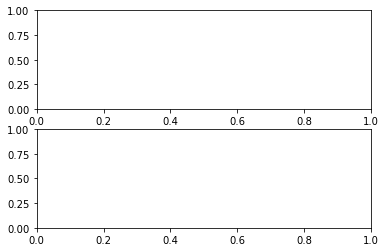

In [128]:
fig,ax = plt.subplot_mosaic('''A
                               B''')

for i,j in transition.items():
    if (i[0][0] == 'sws') and (i[0][1])== 'Rem' and (i[1][0] == 'sws') : 
        if np.any(j):
            plt.sca(ax['A'])
            bk.plot.intervals(j,'blue')
            print(i)
plt.sca(ax['B'])
bk.plot.intervals(states['Rem'],'orange')
bk.plot.intervals(states['sws'],'grey')

In [60]:
metadata

,Rat,Day,Shank,Id,Region,Type
0,11,22,1,2,BMP,Pyr
1,11,22,1,3,BMP,Pyr
2,11,22,3,2,BMP,Pyr
3,11,22,3,3,BMP,Int
4,11,22,3,4,BMP,Pyr
5,11,22,3,5,BMP,Pyr
6,11,22,3,6,BMP,Int
7,11,22,4,2,Pir,Pyr
8,11,22,4,3,Pir,Pyr
9,11,22,4,4,Pir,Pyr


In [4]:
# transition_interest = [('Rem','sws'),('sws','Rem'),('Rem','wake')]
# s = "ABC"
# fig,ax = plt.subplot_mosaic('ABC')
# for ii,i in enumerate(transition_interest):
#     binned = []
#     for event,trans_time in zip(transitions[i].as_units('s').iloc,times[i].as_units('s').index.values):
#         print(trans_time)
#         print('he')
#         start = event.start
#         end = event.end
        
#         if (end-trans_time)<50 or (trans_time-start) <50: continue
# #         if (end-trans_time) > 180: end = trans_time+120
# #         if (trans_time-start) > 180: start = trans_time-120
        
        
        
#         t_pre,b_pre = bk.compute.binSpikes(neurons,start = start,stop = trans_time,nbins=30)
#         t_post,b_post = bk.compute.binSpikes(neurons,start = trans_time,stop = end,nbins=12)
#         b_pre = b_pre/((trans_time-start)/30)
#         b_post = b_post/((end-trans_time)/12)
#         t = np.hstack((t_pre,t_post))
#         b = np.hstack((b_pre,b_post))
        
# #         plt.figure()
# #         plt.plot(t,b.T)
# #         plt.axvline(trans_time,color = 'red')
#         binned.append(b)
#     ax[s[ii]].plot(np.mean(binned,0).T)
    
# plt.suptitle('Transition')